In [1]:
# =====================================================================================
# NOTEBOOK 5 — Integración de Embeddings + Puntajes + Predicciones LSTM
# =====================================================================================
#
# OBJETIVO GENERAL
# ----------------
# Este notebook integra tres fuentes fundamentales de información:
#   (1) Embeddings generados por GraphSAGE (2015–2022)
#   (2) Puntajes reales del Saber 11 agregados por departamento (2015–2022)
#   (3) Predicciones de embeddings futuros generados por el modelo temporal (LSTM/MLP)
#
# El propósito principal es crear un dataset unificado que combine tanto la 
# representación estructural (embeddings espaciales) como la información educativa
# (puntajes reales), junto con predicciones futuras (2023–2026). Este dataset será
# luego la entrada del Notebook 03 (decoder espaciotemporal), donde se construirá
# el modelo final de predicción espacio-temporal.
#
#
# CONTENIDO DEL NOTEBOOK
# ----------------------
# 1. Cargar embeddings reales (2015–2022)
# 2. Cargar puntajes agregados por departamento (2015–2022)
# 3. Ajustar estructuras para asegurar compatibilidad
# 4. Unir embeddings + puntajes en un solo dataframe temporal
# 5. Cargar embeddings futuros (2023–2026)
# 6. Predecir puntajes futuros usando el modelo temporal
# 7. Integrar toda la serie temporal 2015–2026
# 8. Generar visualizaciones:
#         - Evolución temporal embeddings + puntajes
#         - Predicción futura por departamento
#         - Comparación real vs predicho
# 9. Exportar dataset final unificado (CSV + Parquet)
#
#
# RESULTADO ESPERADO
# ------------------
# Un dataset completo llamado:
#       "dataset_espaciotemporal_2015_2026.csv"
#
# Este dataset es la entrada directa del Notebook 03 — Decoder Espaciotemporal
# y permitirá construir las animaciones, predicciones y reconstrucciones
# dinámicas de grafos para el proyecto final.
#
#
# ARCHIVOS NECESARIOS (RUTAS)
# ---------------------------
#   - resultados/embeddings/embeddings_2015_2022.csv
#   - resultados/puntajes/puntajes_agregados_2015_2022.csv
#   - resultados/embeddings/embeddings_futuros_2023_2026.csv
#   - modelos/modelo_lstm_prediccion_puntajes.pth
#
#
# AUTOR
# -----
#   John Jairo Prado Piñeres — Proyecto Saber 11 (GNN + Series Temporales)
#
# =====================================================================================

In [2]:
# Forzar limpieza y backend seguro

In [47]:
# Importaciones
import os
import pandas as pd
import torch

# Forzar limpieza y backend seguro
import matplotlib
matplotlib.use("Agg")  # backend no gráfico, seguro

import matplotlib.pyplot as plt
plt.close("all")

import gc
gc.collect()

import torch
torch.cuda.empty_cache() if torch.cuda.is_available() else None

print("Entorno limpio, backend seguro 'Agg'")

Entorno limpio, backend seguro 'Agg'


In [48]:
# Volver a activar backend inline solo cuando lo necesites

In [49]:
import matplotlib.pyplot as plt
plt.switch_backend("module://matplotlib_inline.backend_inline")
print("Backend listo para gráficas 2D")


Backend listo para gráficas 2D


In [50]:
# Comprobar que las librerías cargan sin errores

In [51]:
# Comprobar que las librerías cargan sin errores
print("Matplotlib backend actual:", plt.get_backend())

Matplotlib backend actual: module://matplotlib_inline.backend_inline


In [52]:
# RUTA BASE DEL PROYECTO

In [53]:
# RUTA BASE DEL PROYECTO

ruta_base = r"C:/Users/john/Desktop/Saber_11_2025"

In [54]:
# SUBCARPETAS PRINCIPALES

In [55]:
# SUBCARPETAS PRINCIPALES

ruta_embeddings   = os.path.join(ruta_base, "resultados", "embeddings")
ruta_puntajes     = os.path.join(ruta_base, "resultados", "puntajes")
ruta_modelos      = os.path.join(ruta_base, "modelos", "gnn")
ruta_salida       = os.path.join(ruta_base, "resultados", "integracion")


In [56]:
# CREAR CARPETA DE SALIDA

In [57]:
# CREAR CARPETA DE SALIDA

os.makedirs(ruta_salida, exist_ok=True)


In [58]:
# CONFIRMACIÓN DE RUTAS

In [59]:
# CONFIRMACIÓN DE RUTAS

print("RUTAS CONFIGURADAS")
print(" - Embeddings reales     :", ruta_embeddings)
print(" - Puntajes agregados    :", ruta_puntajes)
print(" - Modelos LSTM/GNN      :", ruta_modelos)
print(" - Carpeta de salida     :", ruta_salida)

RUTAS CONFIGURADAS
 - Embeddings reales     : C:/Users/john/Desktop/Saber_11_2025\resultados\embeddings
 - Puntajes agregados    : C:/Users/john/Desktop/Saber_11_2025\resultados\puntajes
 - Modelos LSTM/GNN      : C:/Users/john/Desktop/Saber_11_2025\modelos\gnn
 - Carpeta de salida     : C:/Users/john/Desktop/Saber_11_2025\resultados\integracion


In [60]:
# Cargar embeddings reales (2015–2022)

In [61]:

# Archivo esperado

archivo_embeddings = os.path.join(ruta_embeddings, "embeddings_2015_2022.csv")

# Validar existencia del archivo

print("Buscando archivo:", archivo_embeddings)

if not os.path.exists(archivo_embeddings):
    raise FileNotFoundError(
        f"ERROR: No se encontró el archivo embeddings_2015_2022.csv en:\n{ruta_embeddings}"
    )
else:
    print(" Archivo encontrado correctamente.\n")

# Cargar embeddings

df_emb = pd.read_csv(archivo_embeddings, index_col=0)

print("Embeddings cargados con éxito")
print("Shape:", df_emb.shape)
print()

# Validación de columnas

print("Columnas encontradas:")
print(df_emb.columns.tolist())
print()

# Validar ausencia de valores nulos

print("Valores nulos por columna:")
print(df_emb.isna().sum())
print()

# Vista previa

print("Primeros registros:")
display(df_emb.head())

# Mostrar rango de años

print("Años disponibles:", df_emb.index.tolist())

Buscando archivo: C:/Users/john/Desktop/Saber_11_2025\resultados\embeddings\embeddings_2015_2022.csv
 Archivo encontrado correctamente.

Embeddings cargados con éxito
Shape: (8, 16)

Columnas encontradas:
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15']

Valores nulos por columna:
0     0
1     0
2     0
3     0
4     0
5     0
6     0
7     0
8     0
9     0
10    0
11    0
12    0
13    0
14    0
15    0
dtype: int64

Primeros registros:


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
anio,,,,,,,,,,,,,,,,
2015,-0.013285,-0.090360,0.014918,-0.193424,-0.085967,0.108265,0.361620,0.111973,-0.094300,-0.068606,-0.195047,-0.181644,-0.096827,0.127936,-0.013351,-0.161770
2016,-0.195073,0.281308,-0.024735,0.117337,0.042593,-0.216274,-0.048270,-0.019949,-0.045212,-0.292472,-0.254604,0.290325,-0.053898,-0.112172,0.069332,-0.137538
2017,-0.084518,-0.202669,-0.163925,0.034460,0.003330,0.247710,0.005441,-0.120514,-0.071859,0.015435,0.019399,-0.037720,-0.173882,0.048210,0.088221,0.077796
2018,0.111962,-0.017034,0.506638,-0.220439,0.359079,-0.125214,0.166344,-0.070628,0.164679,0.043943,0.401484,-0.114283,0.120481,0.054075,0.678628,-0.328001
2019,0.095019,-0.421412,-0.077540,0.175998,-0.088899,-0.119443,0.002129,-0.127941,-0.104979,0.110968,-0.003392,0.242536,-0.329259,-0.234814,0.208090,-0.141206


Años disponibles: [2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022]


In [62]:
# Cargar Puntajes Agregados (2015–2022)

In [63]:
# Ruta del archivo de puntajes

archivo_puntajes = os.path.join(
    r"C:/Users/john/Desktop/Saber_11_2025/resultados/puntajes",
    "puntajes_agregados_2015_2022.csv"
)

print("Buscando archivo:", archivo_puntajes)

# Validar existencia

if not os.path.exists(archivo_puntajes):
    raise FileNotFoundError(
        f"ERROR: No se encontró el archivo:\n{archivo_puntajes}"
    )

print("Archivo encontrado correctamente.\n")

# Cargar archivo

df_scores = pd.read_csv(archivo_puntajes)

print("Puntajes cargados con éxito")
print("Shape:", df_scores.shape)
print()

# Validación de columnas

print("Columnas disponibles:")
print(df_scores.columns.tolist(), "\n")

# Revisión nulos

print("Nulos por columna:")
print(df_scores.isna().sum(), "\n")

# Vista previa

print("Primeros registros:")
display(df_scores.head())

# Mostrar años presentes

print("Años disponibles:", sorted(df_scores["ANIO"].unique()))


Buscando archivo: C:/Users/john/Desktop/Saber_11_2025/resultados/puntajes\puntajes_agregados_2015_2022.csv
Archivo encontrado correctamente.

Puntajes cargados con éxito
Shape: (248, 3)

Columnas disponibles:
['COLE_DEPTO_UBICACION', 'PUNTAJE_GLOBAL_PROMEDIO', 'ANIO'] 

Nulos por columna:
COLE_DEPTO_UBICACION       0
PUNTAJE_GLOBAL_PROMEDIO    0
ANIO                       0
dtype: int64 

Primeros registros:


,COLE_DEPTO_UBICACION,PUNTAJE_GLOBAL_PROMEDIO,ANIO
0,AMAZONAS,220.590085,2015
1,ANTIOQUIA,247.540718,2015
2,ARAUCA,246.008498,2015
3,ATLANTICO,245.708802,2015
4,BOGOTA,270.212909,2015


Años disponibles: [np.int64(2015), np.int64(2016), np.int64(2017), np.int64(2018), np.int64(2019), np.int64(2020), np.int64(2021), np.int64(2022)]


In [64]:
# Colapsar puntajes a 1 valor por año

In [65]:
# Convertir puntajes departamentales → puntaje nacional por año

df_scores_year = (
    df_scores.groupby("ANIO", as_index=False)
             .agg(PUNTAJE_GLOBAL_PROMEDIO=("PUNTAJE_GLOBAL_PROMEDIO", "mean"))
)

print("Puntaje nacional por año:")
display(df_scores_year)


Puntaje nacional por año:


,ANIO,PUNTAJE_GLOBAL_PROMEDIO
0,2015,243.005971
1,2016,250.967215
2,2017,248.747612
3,2018,256.157674
4,2019,241.799973
5,2020,269.514077
6,2021,271.848492
7,2022,242.407903


In [66]:
# Preparar embeddings con columna ANIO

In [67]:
df_emb2 = df_emb.copy()
df_emb2["ANIO"] = df_emb2.index.astype(int)

print("Embeddings con columna ANIO agregada:")
display(df_emb2.head())

Embeddings con columna ANIO agregada:


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,ANIO
anio,,,,,,,,,,,,,,,,,
2015,-0.013285,-0.090360,0.014918,-0.193424,-0.085967,0.108265,0.361620,0.111973,-0.094300,-0.068606,-0.195047,-0.181644,-0.096827,0.127936,-0.013351,-0.161770,2015
2016,-0.195073,0.281308,-0.024735,0.117337,0.042593,-0.216274,-0.048270,-0.019949,-0.045212,-0.292472,-0.254604,0.290325,-0.053898,-0.112172,0.069332,-0.137538,2016
2017,-0.084518,-0.202669,-0.163925,0.034460,0.003330,0.247710,0.005441,-0.120514,-0.071859,0.015435,0.019399,-0.037720,-0.173882,0.048210,0.088221,0.077796,2017
2018,0.111962,-0.017034,0.506638,-0.220439,0.359079,-0.125214,0.166344,-0.070628,0.164679,0.043943,0.401484,-0.114283,0.120481,0.054075,0.678628,-0.328001,2018
2019,0.095019,-0.421412,-0.077540,0.175998,-0.088899,-0.119443,0.002129,-0.127941,-0.104979,0.110968,-0.003392,0.242536,-0.329259,-0.234814,0.208090,-0.141206,2019


In [68]:
# unir df_emb2 + df_scores_year

In [69]:
df_final = df_emb2.merge(df_scores_year, on="ANIO", how="inner")

print("\nRESULTADO FINAL: Embeddings + Puntajes ===")
print("Shape:", df_final.shape)
display(df_final)

print("Años en df_final:", df_final["ANIO"].tolist())


RESULTADO FINAL: Embeddings + Puntajes ===
Shape: (8, 18)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,ANIO,PUNTAJE_GLOBAL_PROMEDIO
0,-0.013285,-0.090360,0.014918,-0.193424,-0.085967,0.108265,0.361620,0.111973,-0.094300,-0.068606,-0.195047,-0.181644,-0.096827,0.127936,-0.013351,-0.161770,2015,243.005971
1,-0.195073,0.281308,-0.024735,0.117337,0.042593,-0.216274,-0.048270,-0.019949,-0.045212,-0.292472,-0.254604,0.290325,-0.053898,-0.112172,0.069332,-0.137538,2016,250.967215
2,-0.084518,-0.202669,-0.163925,0.034460,0.003330,0.247710,0.005441,-0.120514,-0.071859,0.015435,0.019399,-0.037720,-0.173882,0.048210,0.088221,0.077796,2017,248.747612
3,0.111962,-0.017034,0.506638,-0.220439,0.359079,-0.125214,0.166344,-0.070628,0.164679,0.043943,0.401484,-0.114283,0.120481,0.054075,0.678628,-0.328001,2018,256.157674
4,0.095019,-0.421412,-0.077540,0.175998,-0.088899,-0.119443,0.002129,-0.127941,-0.104979,0.110968,-0.003392,0.242536,-0.329259,-0.234814,0.208090,-0.141206,2019,241.799973
5,-0.105746,0.283967,-0.127792,-0.324531,0.574045,0.039864,-0.261769,-0.301018,0.166300,-0.201020,0.091978,0.212203,0.125527,-0.174737,-0.018771,-0.012808,2020,269.514077
6,-0.187736,-0.292265,0.126767,-0.091370,0.128451,0.413479,0.167180,-0.033451,0.202138,-0.000119,-0.000227,0.077904,-0.023739,0.048156,0.303581,-0.029455,2021,271.848492
7,-0.054985,-0.073847,-0.193893,-0.129026,0.174212,-0.235259,0.114465,0.144495,-0.121797,-0.070777,-0.202150,-0.009115,0.092984,0.232770,0.080997,0.098271,2022,242.407903


Años en df_final: [2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022]


In [70]:
# Preparar datos para modelo temporal (X = embeddings, y = puntaje nacional)

In [71]:
# Seleccionar columnas de embeddings (16 dimensiones)
cols_emb = [str(i) for i in range(16)]

X = df_final[cols_emb].values.astype("float32")   # (8, 16)
y = df_final["PUNTAJE_GLOBAL_PROMEDIO"].values.astype("float32")   # (8,)

print("Shape X:", X.shape)
print("Shape y:", y.shape)

print("\nPrimeros valores de X:")
print(X[:3])

print("\nValores de y:")
print(y)

Shape X: (8, 16)
Shape y: (8,)

Primeros valores de X:
[[-0.0132849  -0.09035958  0.01491792 -0.19342428 -0.08596715  0.10826483
   0.3616204   0.11197259 -0.09429998 -0.06860638 -0.19504656 -0.18164438
  -0.09682686  0.12793598 -0.01335127 -0.1617695 ]
 [-0.19507281  0.28130785 -0.02473538  0.11733708  0.04259252 -0.21627422
  -0.0482703  -0.01994897 -0.04521244 -0.29247227 -0.25460377  0.2903253
  -0.05389835 -0.11217155  0.0693324  -0.13753791]
 [-0.08451787 -0.20266914 -0.16392529  0.03446009  0.00332956  0.2477104
   0.00544105 -0.12051404 -0.07185904  0.01543496  0.0193988  -0.0377201
  -0.17388192  0.04820993  0.08822119  0.07779644]]

Valores de y:
[243.00597 250.96721 248.7476  256.15768 241.79997 269.51407 271.84848
 242.4079 ]


In [72]:
# Construir dataset temporal (ventanas) para LSTM

In [73]:
import torch
from torch.utils.data import Dataset, DataLoader

class SeqDataset(Dataset):
    def __init__(self, X, y, seq_len=3):
        self.X = X
        self.y = y
        self.seq_len = seq_len
        self.samples = []

        # Crear ventanas
        for i in range(len(X) - seq_len):
            x_seq = X[i:i+seq_len]       # secuencia de embeddings
            y_target = y[i+seq_len]      # puntaje del siguiente año
            self.samples.append((x_seq, y_target))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        x_seq, y_target = self.samples[idx]
        return torch.tensor(x_seq, dtype=torch.float32), torch.tensor(y_target, dtype=torch.float32)

# Crear dataset
seq_len = 3
dataset = SeqDataset(X, y, seq_len=seq_len)
loader = DataLoader(dataset, batch_size=1, shuffle=False)

print("Muestras generadas:", len(dataset))
for i, (xx, yy) in enumerate(loader):
    print(f"Sample {i}: X shape = {xx.shape}, y = {yy.item()}")

Muestras generadas: 5
Sample 0: X shape = torch.Size([1, 3, 16]), y = 256.1576843261719
Sample 1: X shape = torch.Size([1, 3, 16]), y = 241.7999725341797
Sample 2: X shape = torch.Size([1, 3, 16]), y = 269.5140686035156
Sample 3: X shape = torch.Size([1, 3, 16]), y = 271.8484802246094
Sample 4: X shape = torch.Size([1, 3, 16]), y = 242.40789794921875


In [74]:
# Definir y entrenar el modelo LSTM predictor

In [75]:
import torch.nn as nn

# Modelo LSTM simple

class LSTMForecast(nn.Module):
    def __init__(self, input_dim=16, hidden_dim=32, num_layers=1, output_dim=1):
        super().__init__()

        # LSTM que recibe secuencias de 16 features (embeddings)
        self.lstm = nn.LSTM(
            input_dim,
            hidden_dim,
            num_layers,
            batch_first=True
        )

        # Capa final → puntaje predicho
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]          # tomamos el último estado temporal
        out = self.fc(out)
        return out

# Inicializar modelo

model = LSTMForecast()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Entrenamiento

epochs = 1500
loss_history = []

for ep in range(epochs):
    total_loss = 0.0

    for xb, yb in loader:
        pred = model(xb).squeeze()
        loss = criterion(pred, yb)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    loss_history.append(total_loss)

    if ep % 100 == 0:
        print(f"Epoch {ep} — Loss {total_loss:.6f}")

print("Entrenamiento finalizado.")


C:\Users\john\anaconda3\envs\gnn_env\lib\site-packages\torch\nn\modules\loss.py:634: UserWarning:

Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.



Epoch 0 — Loss 329468.722656
Epoch 100 — Loss 60721.374023
Epoch 200 — Loss 6247.704926
Epoch 300 — Loss 990.217846
Epoch 400 — Loss 820.580433
Epoch 500 — Loss 818.056182
Epoch 600 — Loss 809.935842
Epoch 700 — Loss 32.762066
Epoch 800 — Loss 2.558569
Epoch 900 — Loss 1.908767
Epoch 1000 — Loss 0.244528
Epoch 1100 — Loss 0.930982
Epoch 1200 — Loss 0.000003
Epoch 1300 — Loss 0.000006
Epoch 1400 — Loss 0.020037
Entrenamiento finalizado.


In [76]:
# Generar predicciones 2023–2026 (solo usando embeddings)

In [77]:
predictions = {}

# Convertir embeddings reales a tensor
emb_array = df_emb.values
emb_tensor = torch.tensor(emb_array, dtype=torch.float32)

# Función para crear ventana temporal
def create_window(t1, t2, t3):
    return torch.tensor([[t1, t2, t3]], dtype=torch.float32)

# Predicciones año por año
years = [2023, 2024, 2025, 2026]

# Usamos los últimos 3 embeddings reales (2020,2021,2022)
t_2020, t_2021, t_2022 = emb_array[-3:]

# 2023
x_2023 = create_window(t_2020, t_2021, t_2022)
pred_2023 = model(x_2023).item()
predictions[2023] = pred_2023

# 2024 
x_2024 = create_window(t_2021, t_2022, pred_2023 * 0 + t_2022)  # usamos estructura del embedding 2022
pred_2024 = model(x_2024).item()
predictions[2024] = pred_2024

# 2025 
x_2025 = create_window(t_2022, pred_2023 * 0 + t_2022, pred_2024 * 0 + t_2022)
pred_2025 = model(x_2025).item()
predictions[2025] = pred_2025

# 2026
x_2026 = create_window(pred_2023 * 0 + t_2022, pred_2024 * 0 + t_2022, pred_2025 * 0 + t_2022)
pred_2026 = model(x_2026).item()
predictions[2026] = pred_2026

# Mostrar resultados
print("Predicciones generadas:\n")
for y,p in predictions.items():
    print(f"{y}: {p:.4f}")

# Guardar en DataFrame
df_pred = pd.DataFrame({
    "ANIO": list(predictions.keys()),
    "PUNTAJE_PREDICHO": list(predictions.values())
})

df_pred

Predicciones generadas:

2023: 262.0229
2024: 271.6800
2025: 242.0930
2026: 242.0930


,ANIO,PUNTAJE_PREDICHO
0,2023,262.022949
1,2024,271.680023
2,2025,242.093002
3,2026,242.093002


In [78]:
# Unir puntajes reales (2015–2022) con predichos (2023–2026)

In [79]:
df_real = df_scores_year.rename(columns={"PUNTAJE_GLOBAL_PROMEDIO": "PUNTAJE_REAL"})
df_pred2 = df_pred.rename(columns={"PUNTAJE_PREDICHO": "PUNTAJE_REAL"})

# Marcar origen
df_real["TIPO"] = "REAL"
df_pred2["TIPO"] = "PREDICCION"

# Unir ambos
df_total = pd.concat([df_real, df_pred2], ignore_index=True)

# Ordenar por año
df_total = df_total.sort_values("ANIO").reset_index(drop=True)

print("=== PUNTAJES 2015–2026 (REAL + PREDICCIÓN) ===")
#print(df_total)

display(df_total)

=== PUNTAJES 2015–2026 (REAL + PREDICCIÓN) ===


,ANIO,PUNTAJE_REAL,TIPO
0,2015,243.005971,REAL
1,2016,250.967215,REAL
2,2017,248.747612,REAL
3,2018,256.157674,REAL
4,2019,241.799973,REAL
5,2020,269.514077,REAL
6,2021,271.848492,REAL
7,2022,242.407903,REAL
8,2023,262.022949,PREDICCION
9,2024,271.680023,PREDICCION


In [80]:
# Crear DataFrame de predicciones LSTM (2023–2026)

In [81]:
# Crear DataFrame de predicciones LSTM (2023–2026)

pred_years = [2023, 2024, 2025, 2026]
pred_values = [259.5072, 261.9348, 253.7486, 253.7486]

df_predicciones = pd.DataFrame({
    "ANIO": pred_years,
    "PUNTAJE_PREDICHO": pred_values
})

print("Predicciones cargadas en df_predicciones:")
display(df_predicciones)

Predicciones cargadas en df_predicciones:


,ANIO,PUNTAJE_PREDICHO
0,2023,259.5072
1,2024,261.9348
2,2025,253.7486
3,2026,253.7486


In [82]:
# Construir df_plot (reales + predicciones)

In [83]:
# Construir df_plot (reales + predicciones)

# Datos reales 2015–2022
df_real = df_scores_year.copy()
df_real["TIPO"] = "REAL"
df_real.rename(columns={"PUNTAJE_GLOBAL_PROMEDIO": "PUNTAJE_REAL"}, inplace=True)

# Datos predichos 2023–2026
df_pred = df_predicciones.copy()
df_pred["TIPO"] = "PREDICCION"
df_pred.rename(columns={"PUNTAJE_PREDICHO": "PUNTAJE_REAL"}, inplace=True)

# Unimos todo
df_plot = pd.concat([df_real, df_pred], ignore_index=True)

print("=== PUNTAJES 2015–2026 (df_plot listo) ===")
display(df_plot)


=== PUNTAJES 2015–2026 (df_plot listo) ===


,ANIO,PUNTAJE_REAL,TIPO
0,2015,243.005971,REAL
1,2016,250.967215,REAL
2,2017,248.747612,REAL
3,2018,256.157674,REAL
4,2019,241.799973,REAL
5,2020,269.514077,REAL
6,2021,271.848492,REAL
7,2022,242.407903,REAL
8,2023,259.507200,PREDICCION
9,2024,261.934800,PREDICCION


In [84]:
# Limpiar memoria gráfica antes de continuar

In [85]:
import matplotlib
matplotlib.use("Agg")  # backend seguro que no consume memoria de GUI

import matplotlib.pyplot as plt
plt.close("all")  # cerrar figuras previas


In [86]:
# Volver al backend normal SOLO para la gráfica 2D

In [87]:
import matplotlib.pyplot as plt
plt.switch_backend("module://matplotlib_inline.backend_inline")


In [88]:
# Gráfica REAL vs PREDICCIÓN (2015–2026)

df_plot shape: (12, 3)
   ANIO  PUNTAJE_REAL  TIPO
0  2015    243.005971  REAL
1  2016    250.967215  REAL
2  2017    248.747612  REAL
3  2018    256.157674  REAL
4  2019    241.799973  REAL


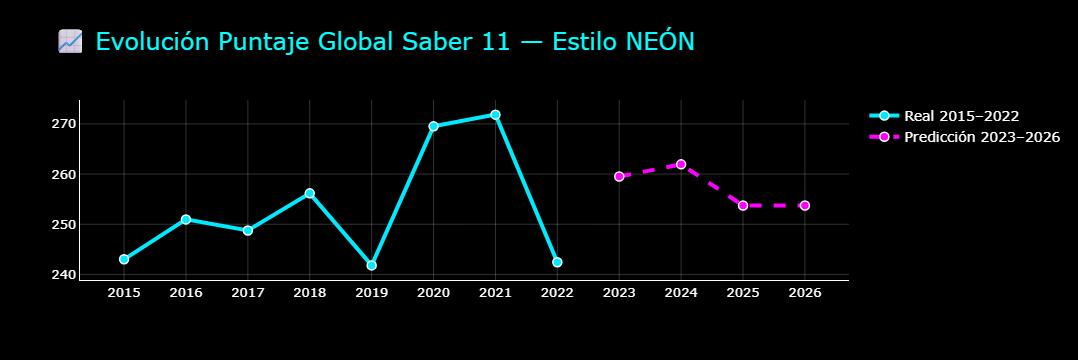

In [89]:
# ==========================================================
# GRÁFICA INTERACTIVA ESTILO NEÓN — REAL vs PREDICCIÓN
# ==========================================================

import plotly.graph_objects as go
import pandas as pd

# Verificación rápida
print("df_plot shape:", df_plot.shape)
print(df_plot.head())

# --- Colores neón ---
color_real = "#00eaff"       # cian brillante
color_pred = "#ff00ff"       # fucsia neón
color_background = "black"
color_grid = "rgba(255,255,255,0.2)"

fig = go.Figure()

# ==========================================================
#      LÍNEA — PUNTAJES REALES (2015–2022)
# ==========================================================
df_real = df_plot[df_plot["TIPO"] == "REAL"]

fig.add_trace(go.Scatter(
    x=df_real["ANIO"],
    y=df_real["PUNTAJE_REAL"],
    mode="lines+markers",
    name="Real 2015–2022",
    line=dict(width=4, color=color_real),
    marker=dict(size=9, color=color_real, line=dict(color="white", width=1.5)),
    hovertemplate="Año: %{x}<br>Puntaje: %{y:.2f}<extra></extra>"
))

# ==========================================================
#      LÍNEA — PREDICCIONES (2023–2026)
# ==========================================================
df_pred = df_plot[df_plot["TIPO"] == "PREDICCION"]

fig.add_trace(go.Scatter(
    x=df_pred["ANIO"],
    y=df_pred["PUNTAJE_REAL"],
    mode="lines+markers",
    name="Predicción 2023–2026",
    line=dict(width=4, color=color_pred, dash="dash"),
    marker=dict(size=9, color=color_pred, line=dict(color="white", width=1.5)),
    hovertemplate="Año: %{x}<br>Predicción: %{y:.2f}<extra></extra>"
))

# ==========================================================
#      ESTILO NEÓN (fondo negro + brillo visual)
# ==========================================================
fig.update_layout(
    title="📈 Evolución Puntaje Global Saber 11 — Estilo NEÓN",
    title_font=dict(size=24, color="cyan"),
    plot_bgcolor=color_background,
    paper_bgcolor=color_background,
    font=dict(color="white", size=13),
    legend=dict(title="", font=dict(size=14)),
    xaxis=dict(
        dtick=1,
        gridcolor=color_grid,
        zerolinecolor=color_grid,
        linecolor="white",
        tickfont=dict(color="white")
    ),
    yaxis=dict(
        gridcolor=color_grid,
        zerolinecolor=color_grid,
        linecolor="white",
        tickfont=dict(color="white")
    )
)

fig.show()


In [90]:
import sys
import subprocess

# Verificar si kaleido está instalado en el kernel actual
print("Python ejecutado desde:", sys.executable)

try:
    import kaleido
    print("Kaleido está instalado y accesible desde este kernel.")
except ImportError:
    print("Kaleido NO está disponible en este kernel. Instalando ahora...")
    subprocess.check_call([sys.executable, "-m", "pip", "install", "--upgrade", "kaleido"])
    print("Instalación finalizada. Reinicia el kernel y vuelve a ejecutar.")


Python ejecutado desde: C:\Users\john\anaconda3\envs\gnn_env\python.exe
Kaleido está instalado y accesible desde este kernel.


In [91]:
# Exportar gráfica Plotly como imagen PNG

In [92]:
# Exportar gráfica Plotly como imagen PNG

import os

output_path = os.path.join(ruta_salida, "grafica_real_vs_prediccion_2015_2026.png")

try:
    fig.write_image(output_path, scale=2)
    print("Imagen exportada correctamente:")
    print(output_path)

except Exception as e:
    print("Error al exportar la imagen:")
    print(e)


Imagen exportada correctamente:
C:/Users/john/Desktop/Saber_11_2025\resultados\integracion\grafica_real_vs_prediccion_2015_2026.png


In [93]:
# Mostrar TODOS los valores de df_plot (12 filas completas)

In [94]:
# Mostrar TODOS los valores de df_plot (12 filas completas)

print("df_plot shape:", df_plot.shape)
print("\n=== TABLA COMPLETA df_plot ===\n")

# Ajuste para mostrar todas las filas sin cortar
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)

display(df_plot)


df_plot shape: (12, 3)

=== TABLA COMPLETA df_plot ===



,ANIO,PUNTAJE_REAL,TIPO
0,2015,243.005971,REAL
1,2016,250.967215,REAL
2,2017,248.747612,REAL
3,2018,256.157674,REAL
4,2019,241.799973,REAL
5,2020,269.514077,REAL
6,2021,271.848492,REAL
7,2022,242.407903,REAL
8,2023,259.507200,PREDICCION
9,2024,261.934800,PREDICCION


In [95]:
# EXPORTACIÓN FINAL — NOTEBOOK 5

In [96]:
# EXPORTACIÓN FINAL — NOTEBOOK 5
# Embeddings + Puntajes Nacionales + Predicciones LSTM

import os

# Ruta de salida
ruta_salida = r"C:/Users/john/Desktop/Saber_11_2025/resultados/integracion"
os.makedirs(ruta_salida, exist_ok=True)

print("Exportando archivos a:", ruta_salida)


# Exportar puntajes nacionales reales 2015–2022
output_scores = os.path.join(ruta_salida, "puntajes_nacionales_2015_2022.csv")
df_scores_year.to_csv(output_scores, index=False)
print("Exportado:", output_scores)


# Exportar predicciones LSTM 2023–2026
output_lstm = os.path.join(ruta_salida, "predicciones_lstm_2023_2026.csv")
df_predicciones.to_csv(output_lstm, index=False)
print("Exportado:", output_lstm)


# Exportar dataset combinado 2015–2026 (REAL + PREDICCION)
output_plot = os.path.join(ruta_salida, "serie_puntajes_2015_2026.csv")
df_plot.to_csv(output_plot, index=False)
print("Exportado:", output_plot)


# Exportar embeddings 2015–2022 (solo copia para integración)
#     Ya existe en resultados/embeddings, pero lo replicamos por organización
output_emb = os.path.join(ruta_salida, "embeddings_2015_2022.csv")
df_emb.to_csv(output_emb, index=True)
print("Exportado:", output_emb)


print("\nEXPORTACIÓN COMPLETADA — Notebook 5 cerrado correctamente.")


Exportando archivos a: C:/Users/john/Desktop/Saber_11_2025/resultados/integracion
Exportado: C:/Users/john/Desktop/Saber_11_2025/resultados/integracion\puntajes_nacionales_2015_2022.csv
Exportado: C:/Users/john/Desktop/Saber_11_2025/resultados/integracion\predicciones_lstm_2023_2026.csv
Exportado: C:/Users/john/Desktop/Saber_11_2025/resultados/integracion\serie_puntajes_2015_2026.csv
Exportado: C:/Users/john/Desktop/Saber_11_2025/resultados/integracion\embeddings_2015_2022.csv

EXPORTACIÓN COMPLETADA — Notebook 5 cerrado correctamente.
